# UCC benchmarks
In this notebook, we benchmark the performance of Unitary Fund's UCC compiler against qiskit, PyTKET and Cirq across a range of benchmarks for circuits of (100 qubits) each unless otherwise marked: 

- Quantum Approximate Optimization Algorithm (QAOA)
- Quantum volume  (QV) calculation
- Quantum Fourier transform (QFT)
- Square Heisenberg model Trotterized Hamiltonian simulation
- Quantum computational neural network (QCNN)
- PREPARE & SELECT on a 25 qubit GHZ state

#### Circuit definitions
For the **QAOA, QFT, Square Heisenberg,** and **QV** circuits, we copy the corresponding [OpenQASM 2 code](https://github.com/qiskit/benchpress/tree/main/benchpress/qasm) from qiskit's benchpress library. For the **QCNN** and **Prepare & Select** circuits, we generate QASM 2 code using our own implementations in qiskit and cirq, decomposed into the restricted basis set:

 `['rz', 'rx', 'ry', 'h', 'cx']`.

In [1]:
folder = "./circuits/qasm2/"

qasm_files = [folder + file for file in [
    "benchpress/qaoa_barabasi_albert_N100_3reps_basis_rz_rx_ry_cx.qasm",
    "benchpress/qv_N100_12345_basis_rz_rx_ry_cx.qasm",
    "benchpress/qft_N100_basis_rz_rx_ry_cx.qasm",
    "benchpress/square_heisenberg_N100_basis_rz_rx_ry_cx.qasm",
    "ucc/prep_select_N25_ghz_basis_rz_rx_ry_h_cx.qasm",
    "ucc/qcnn_N100_7layers_basis_rz_rx_ry_h_cx.qasm"
    ]]

# qasm_files.append("./circuits/qasm3/ucc/VQE_ansatz_N100_25layers.qasm")


#### Transpilation
For all benchmarks, we then use qbraid's [transpile](https://docs.qbraid.com/sdk/user-guide/transpiler) function to translate into the native format each SDK's compiler. 

**Note**: `qbraid.transpile` does NOT perform any circuit optimization; it only translates between circuit representations. 

#### Compilation
We then run a compiler pass on the circuit for each SDK, including decomposition into a target basis set to maintain parity in counting 2-qubit gates (shown below). Since there is not a default set of compiler passes for `Cirq` or `PyTKET`, we chose a subset of those available.  We invite anyone more familiar with these compiler libraries to suggest more optimal passes. 

However, it is worth pointing out that a major goal of UCC is to simplify the process of compilation for quantum developers and provide a "good default" set of passes that is on par with other compilers, without the user needing to specify any additional parameters.

In [2]:
from qiskit import transpile as qiskit_transpile


def qiskit_compile(qiskit_circuit):
    """Compile given qiskit.QuantumCircuit object and return the compiled circuit and total number of raw and compiled 2 qubit gates"""
    compiled_circuit = qiskit_transpile(qiskit_circuit, optimization_level=3, basis_gates=['rz', 'rx', 'ry', 'h', 'cx'])
    
    return compiled_circuit

In [3]:
from cirq.transformers import optimize_for_target_gateset, CZTargetGateset


def cirq_compile(cirq_circuit):
    """Compile given cirq.Circuit object and return the compiled circuit and total number of raw and compiled 2 qubit gates"""
    # Compiler passes
    compiled_circuit = optimize_for_target_gateset(
    cirq_circuit, 
    gateset=CZTargetGateset() 
    )

    return compiled_circuit

In [4]:
# Compile using TKET
from pytket.circuit import OpType
from pytket.predicates import CompilationUnit
from pytket.passes import SequencePass, DecomposeBoxes, auto_rebase_pass, SimplifyInitial, RemoveRedundancies, FullPeepholeOptimise
from pytket.transform import Transform
 
def pytket_compile(pytket_circuit):
    """Compile given pytket.Circuit object and return the compiled circuit and total number of raw and compiled 2 qubit gates"""
    compilation_unit = CompilationUnit(pytket_circuit)

    seqpass = SequencePass([
        # Remove identity and redundant gates
        SimplifyInitial(),   
        # Decompose multi-qubit gates into CNOTs and single-qubit gates
        DecomposeBoxes(),
        # Rebase the circuit to a target gate set: {Rx, Ry, Rz, CX, H}.
        RemoveRedundancies(),  # Remove any remaining redundant gates
        auto_rebase_pass(
            {OpType.Rx, OpType.Ry, OpType.Rz, OpType.CX, OpType.H}),  
        # FullPeepholeOptimise(), # Very slow, extensive optimization
    ])
    
    seqpass.apply(compilation_unit) # In-place

    compiled_circuit = compilation_unit.circuit

    return compiled_circuit

In [5]:
from ucc import compile 

def ucc_compile(circuit):
    """Compile given qiskit.QuantumCircuit and return the compiled circuit and total number of raw and compiled 2 qubit gates"""
    compiled_circuit = compile(circuit)

    return compiled_circuit

In [6]:
from qbraid.transpiler import transpile as translate

def get_native_rep(circuit, compiler_alias):
    """Converts the given circuit to the native representation of the given compiler using qBraid.transpile.
    """
    if alias == 'ucc':
        # Qiskit used for UCC to get raw gate counts
        native_circuit = translate(qasm_string, 'qiskit')
    else:
        native_circuit = translate(qasm_string, alias)

    return native_circuit

In [7]:
from utils import count_multi_qubit_gates_cirq, count_multi_qubit_gates_pytket, count_multi_qubit_gates_qiskit

def count_multi_qubit_gates(circuit, compiler_alias):
    match compiler_alias:
        case 'ucc':
            result = count_multi_qubit_gates_qiskit(circuit)
        case 'qiskit':
            result = count_multi_qubit_gates_qiskit(circuit)
        case 'cirq':
            result = count_multi_qubit_gates_cirq(circuit)
        case 'pytket':
            result = count_multi_qubit_gates_pytket(circuit)
        case _:
            result = "Unknown compiler alias."

    return result

In [8]:
from time import time

def log_performance(compiler_function, raw_circuit, compiler_alias):
    # Should also log the compiler software version
    log_entry = {"compiler": alias}
    log_entry['raw_circuit'] = raw_circuit
    log_entry["raw_multiq_gates"] = count_multi_qubit_gates(
        raw_circuit, compiler_alias
        )

    t1 = time()
    compiled_circuit = compiler_function(raw_circuit)
    t2 = time()
    log_entry["compile_time"] = t2 - t1
    log_entry["compiled_multiq_gates"] = count_multi_qubit_gates(
        compiled_circuit, compiler_alias
        )
    [print(f"{key}: {value}") for key, value in log_entry.items() if key != 'raw_circuit']
    print('\n')
    log_entry['compiled_circuit'] = compiled_circuit
    
    return log_entry

In [9]:
results_log = []

### Profile UCC

In [10]:
compiler_specs = [
    ('ucc', ucc_compile), 
    ('pytket', pytket_compile),
    ('qiskit', qiskit_compile),
    ('cirq', cirq_compile)
]
for filename in qasm_files:
    # Open the QASM file and read its content into a string
    with open(filename, "r") as file:
        print(filename)
        qasm_string = file.read()
        for alias, compile_func in compiler_specs:
            native_circuit = get_native_rep(qasm_string, alias)
            
            log_entry = log_performance(
                compile_func, 
                native_circuit, 
                compiler_alias=alias
                )
            log_entry['circuit_name'] = filename.split('/')[-1].split('_N')[0]
            
            results_log.append(log_entry)
            

./circuits/qasm2/benchpress/qaoa_barabasi_albert_N100_3reps_basis_rz_rx_ry_cx.qasm
compiler: ucc
raw_multiq_gates: 1176
compile_time: 0.14392304420471191
compiled_multiq_gates: 1176


compiler: pytket
raw_multiq_gates: 1176
compile_time: 0.007522106170654297
compiled_multiq_gates: 1176


compiler: qiskit
raw_multiq_gates: 1176
compile_time: 0.21543478965759277
compiled_multiq_gates: 1176


compiler: cirq
raw_multiq_gates: 1176
compile_time: 1.919739007949829
compiled_multiq_gates: 1176


./circuits/qasm2/benchpress/qv_N100_12345_basis_rz_rx_ry_cx.qasm
compiler: ucc
raw_multiq_gates: 15000
compile_time: 3.3503639698028564
compiled_multiq_gates: 14856


compiler: pytket
raw_multiq_gates: 15000
compile_time: 1.973799228668213
compiled_multiq_gates: 15000


compiler: qiskit
raw_multiq_gates: 15000
compile_time: 13.70786714553833
compiled_multiq_gates: 14856


compiler: cirq
raw_multiq_gates: 15000
compile_time: 79.42516779899597
compiled_multiq_gates: 14856


./circuits/qasm2/benchpress/qf

In [11]:
import pandas as pd

# Convert results_log to a DataFrame
df = pd.DataFrame(results_log)

df['reduction_factor'] = df['raw_multiq_gates'] / df['compiled_multiq_gates'] 
df['gate_reduction_per_s'] = df['reduction_factor'] / df['compile_time']
df['compiled_ratio'] = df['compiled_multiq_gates'] / df['raw_multiq_gates']

df_og = pd.DataFrame(results_log)

# Assuming df is your DataFrame
df = df.drop(columns=["compiled_circuit", "raw_circuit"])

df = df.groupby(["circuit_name", "compiler"]).agg(
    compile_time=("compile_time", "mean"),
    raw_multiq_gates=("raw_multiq_gates", "mean"),
    compiled_multiq_gates=("compiled_multiq_gates", "mean"),
    gate_reduction_per_s=("gate_reduction_per_s", "mean"),
    reduction_factor=("reduction_factor", "mean"),
    compiled_ratio=("compiled_ratio", "mean")
).reset_index()


In [12]:
from datetime import datetime

# Generate a timestamp string
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a filename with the timestamp
filename = f"./results/results_{timestamp}.csv"

# Save the DataFrame as a CSV file with the timestamped filename
df.to_csv(filename, index=False)

In [13]:
# Make circuit names shorter for plotting display:
df['circuit_name'] = df['circuit_name'].apply(lambda x: x.split('/')[-1].split('_N')[0])

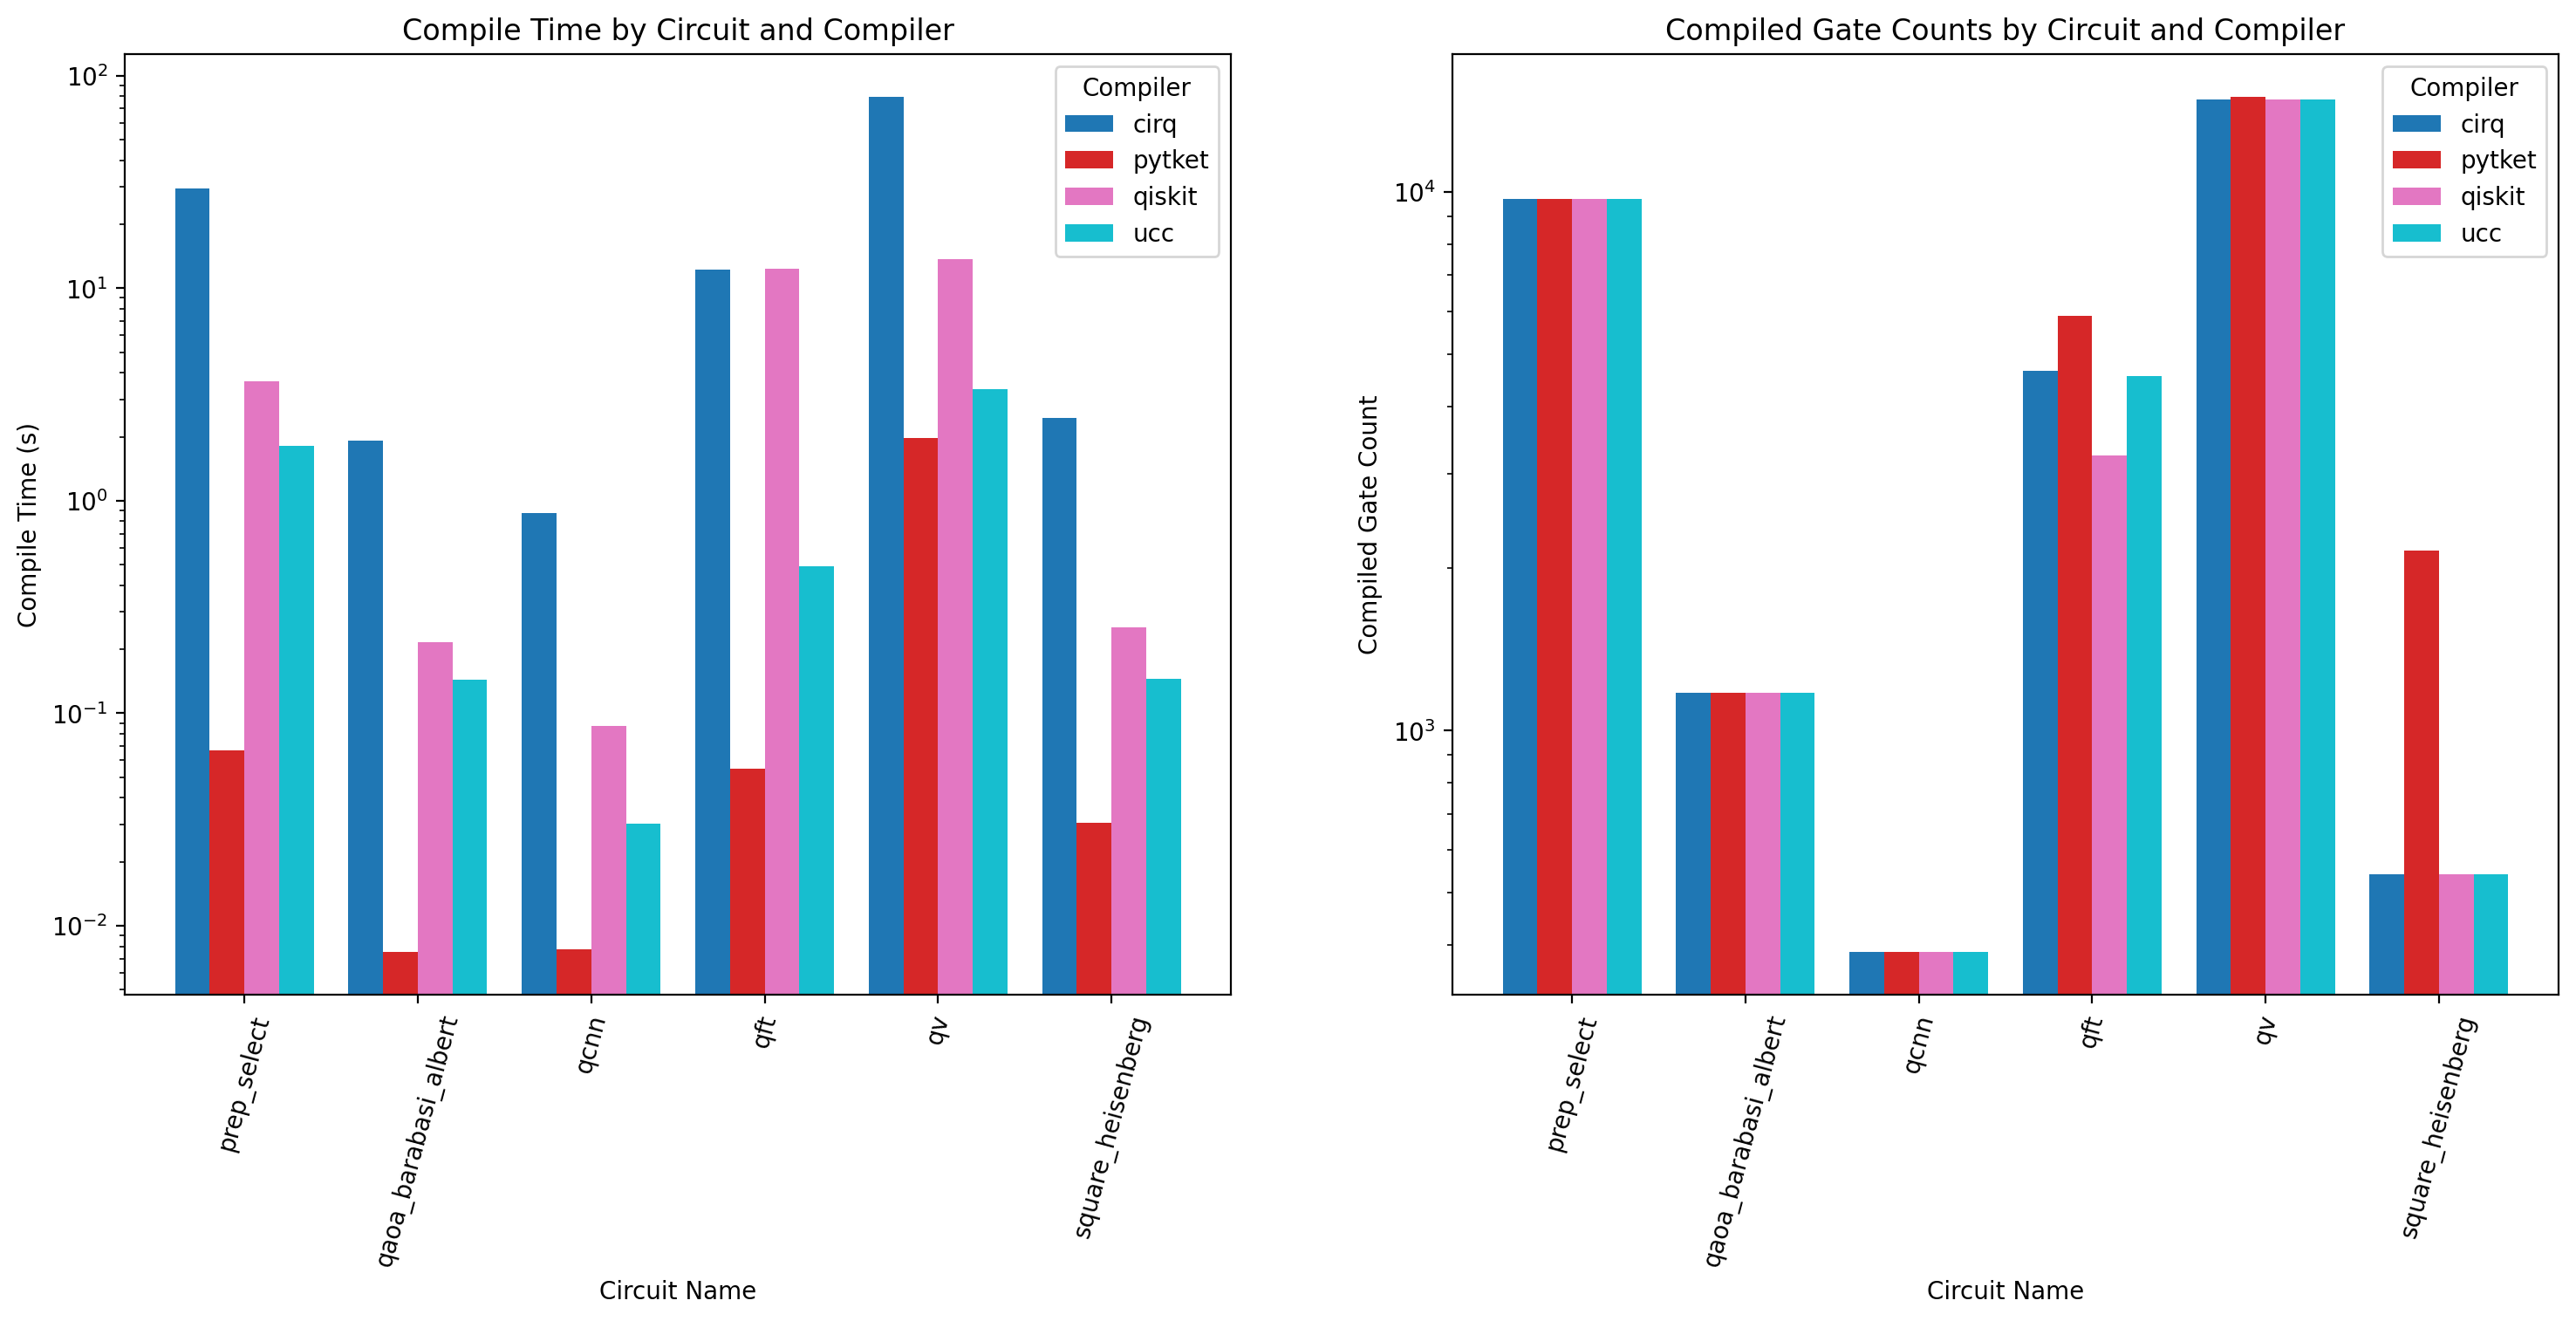

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the default DPI for all figures
mpl.rcParams['figure.dpi'] = 200

# Create a 1x2 subplot grid
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Define a colormap and get unique compilers
unique_compilers = df["compiler"].unique()
colormap = plt.get_cmap("tab10", len(unique_compilers))
color_map = {compiler: colormap(i) for i, compiler in enumerate(unique_compilers)}
label_angle = 75

# Define bar width and x-offset for side-by-side plotting
bar_width = 0.2  # Adjust width to make bars skinnier
x = pd.Series(range(len(df["circuit_name"].unique())))  # X positions for each circuit

# Plot 1: Compile Time by Circuit and Compiler
for i, key in enumerate(unique_compilers):
    # Offset x-positions for each compiler to place bars side-by-side
    grp = df[df["compiler"] == key].sort_values(by=["circuit_name", "compile_time"])
    ax[0].bar(x + i * bar_width, grp["compile_time"], width=bar_width, label=key, color=color_map[key])

# Format the first plot
ax[0].set_title("Compile Time by Circuit and Compiler")
ax[0].set_xlabel("Circuit Name")
ax[0].set_ylabel("Compile Time (s)")
ax[0].set_yscale("log")  # Set log scale
ax[0].set_xticks(x + bar_width * (len(unique_compilers) - 1) / 2)  # Center x-tick labels
ax[0].set_xticklabels(df["circuit_name"].unique())
ax[0].legend(title="Compiler")
ax[0].tick_params(axis='x', rotation=label_angle)  # Rotate x-axis labels

# Plot 2: Compiled Gate Counts by Circuit and Compiler 
for i, key in enumerate(unique_compilers):
    # Offset x-positions for each compiler to place bars side-by-side
    grp = df[df["compiler"] == key].sort_values(by=["circuit_name", "compiled_multiq_gates"])
    ax[1].bar(x + i * bar_width, grp["compiled_multiq_gates"], width=bar_width, label=key, color=color_map[key])

# Format the second plot
ax[1].set_title("Compiled Gate Counts by Circuit and Compiler")
ax[1].set_xlabel("Circuit Name")
ax[1].set_ylabel("Compiled Gate Count")
ax[1].set_yscale("log")  # Set log scale

ax[1].set_xticks(x + bar_width * (len(unique_compilers) - 1) / 2)  # Center x-tick labels
ax[1].set_xticklabels(df["circuit_name"].unique())
ax[1].legend(title="Compiler")
ax[1].tick_params(axis='x', rotation=label_angle)  # Rotate x-axis labels


# Show the plot
# plt.tight_layout()

plt.show()


### Averaging over all benchmark circuits

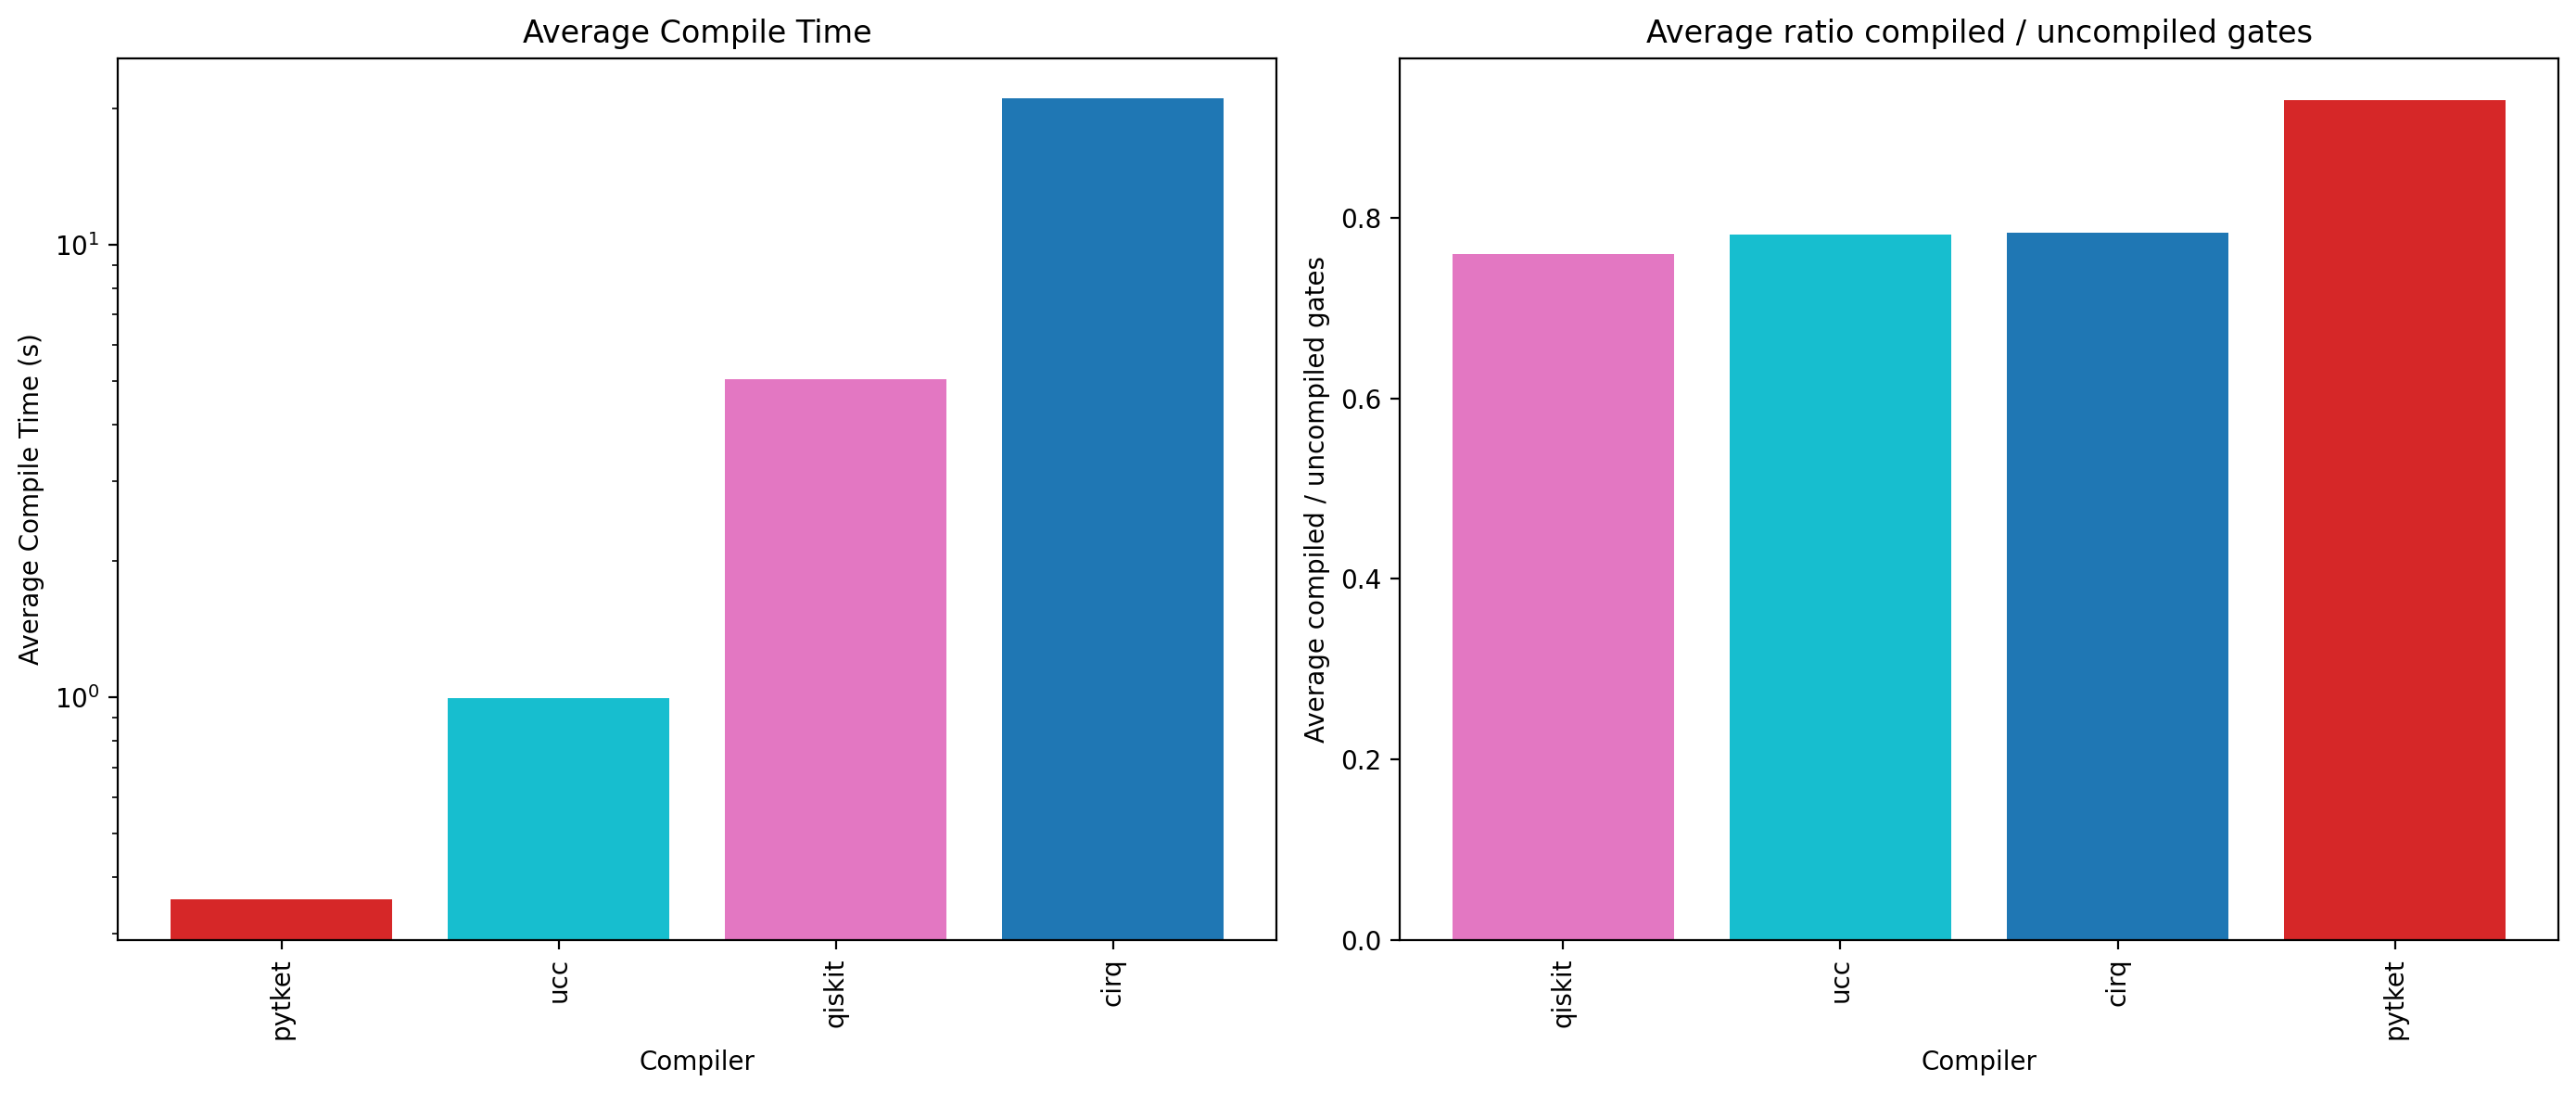

In [15]:
import numpy as np

# Create a figure with 2 subplots: Average Gate Reduction and Average Compile Time
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Average Compile Time across All Circuits
avg_compile_time = df.groupby("compiler")["compile_time"].mean().sort_values()

ax[0].bar(avg_compile_time.index, avg_compile_time.values, 
          color=[color_map[compiler] for compiler in avg_compile_time.index])
ax[0].set_title("Average Compile Time")
ax[0].set_xlabel("Compiler")
ax[0].set_ylabel("Average Compile Time (s)")
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_yscale("log")  # Set log scale


# Plot 2: Average ratio compiled / uncompiled gates
avg_compiled_ratio = df.groupby("compiler")["compiled_ratio"].mean().sort_values()

ax[1].bar(avg_compiled_ratio.index, avg_compiled_ratio.values, 
          color=[color_map[compiler] for compiler in avg_compiled_ratio.index])
ax[1].set_title("Average ratio compiled / uncompiled gates")
ax[1].set_ylabel("Average compiled / uncompiled gates")

ax[1].set_xlabel("Compiler")
ax[1].tick_params(axis='x', rotation=90)

# Show the first figure
plt.tight_layout()
plt.show()


In [16]:
# Function to round to 3 significant figures
def round_to_sigfigs(x, sigfigs=2):
    if isinstance(x, (int, float)):  # Check if the value is numerical
        return round(x, sigfigs - int(np.floor(np.log10(abs(x)))) - 1) if x != 0 else 0
    return x  # Return non-numerical values as-is

# Create a new DataFrame with compile_time data
factor_df = pd.DataFrame(avg_compile_time).reset_index()

# Get the UCC compile time
ucc_factor = factor_df[factor_df.compiler == "ucc"]["compile_time"]

# Calculate the comparison factor (UCC compile time divided by other compilers)
factor_df['ucc_compare_factor'] =  factor_df["compile_time"] / ucc_factor.iloc[0] 

# Apply rounding to 3 significant figures
rounded_df = factor_df.map(round_to_sigfigs)

# Sort the DataFrame by the comparison factor
rounded_df = rounded_df.sort_values(by='ucc_compare_factor')

# Display the sorted, rounded DataFrame
rounded_df


,compiler,compile_time,ucc_compare_factor
0,pytket,0.36,0.36
1,ucc,1.00,1.00
2,qiskit,5.10,5.10
3,cirq,21.00,21.00


In [17]:
# Create a new DataFrame with gate reduction data
ratio_df = pd.DataFrame(avg_compiled_ratio).reset_index()

# Get the UCC gate reduction
ucc_ratio = ratio_df[ratio_df.compiler == "ucc"]["compiled_ratio"]

# Calculate the compiled ratio (each compiler's gate reduction divided by UCC)
ratio_df['ucc_compare_ratio'] = ratio_df["compiled_ratio"] / ucc_ratio.iloc[0]

# Apply rounding to 3 significant figures
rounded_df = ratio_df.map(round_to_sigfigs, sigfigs=3)

# Sort the DataFrame by the comparison factor
rounded_df = rounded_df.sort_values(by='ucc_compare_ratio')


# Display the sorted, rounded DataFrame
rounded_df

,compiler,compiled_ratio,ucc_compare_ratio
0,qiskit,0.760,0.972
1,ucc,0.782,1.000
2,cirq,0.783,1.000
3,pytket,0.930,1.190


In [18]:
# Create a new DataFrame with gate reduction data
factor_df = pd.DataFrame(avg_gate_reduction).reset_index()

# Get the UCC gate reduction
ucc_factor = factor_df[factor_df.compiler == "ucc"]["reduction_factor"]

# Calculate the comparison factor (each compiler's gate reduction divided by UCC)
factor_df['ucc_compare_factor'] = 1/ (factor_df["reduction_factor"] / ucc_factor.iloc[0])

# Apply rounding to 3 significant figures
rounded_df = factor_df.map(round_to_sigfigs)

# Sort the DataFrame by the comparison factor
rounded_df = rounded_df.sort_values(by='ucc_compare_factor').rename(columns={'reduction_factor': 'avg_gate_reduction_factor'})


# Display the sorted, rounded DataFrame
rounded_df

NameError: name 'avg_gate_reduction' is not defined

In [ ]:
# Create a separate figure for average gate reduction per second
fig, ax = plt.subplots(figsize=(5, 4))  # Adjust size to be smaller

# Calculate average gate reduction per second across all circuits
avg_gate_reduction_per_s = df.groupby("compiler")["gate_reduction_per_s"].mean().sort_values()

# Plot Average Gate Reduction per Second
ax.bar(avg_gate_reduction_per_s.index, avg_gate_reduction_per_s.values, 
       color=[color_map[compiler] for compiler in avg_gate_reduction_per_s.index])

ax.set_title("Average Gate Reduction per Second (higher is better)")
ax.set_xlabel("Compiler")
ax.set_ylabel("Average Gate Reduction per Second")
ax.tick_params(axis='x', rotation=90)

# Show the second figure
plt.tight_layout()
plt.show()


In [ ]:
factor_df = pd.DataFrame(avg_gate_reduction_per_s).reset_index()
ucc_factor = factor_df[factor_df.compiler == "ucc"]["gate_reduction_per_s"]

factor_df['ucc_compare_factor'] = ucc_factor.iloc[0] / factor_df["gate_reduction_per_s"]
rounded_df = factor_df.map(round_to_sigfigs)
rounded_df.sort_values(by='ucc_compare_factor')


***A note on terminology***

There is some disagreement in the quantum computing community on the proper usage of the terms "transpilation" and "compilation." For instance, Qiskit refers to optimization of the Directed Acyclic Graph (DAG) of a circuit as "transpilation," whereas in qBraid, the 1:1 translation of one circuit representation into another (e.g. a Cirq circuit to a Qiskit circuit; OpenQASM 2 into PyTKET) without optimization is called "transpilation." Cirq on the other hand appears to use the terminology of "transformers" to refer to what Qiskit calls transpiler passes, which PyTKET appears to call CompilationUnits. 

This cornucopia of intersecting definitions does mean that this notebook necessarily mixes terminology. We feel relatively confident we've interpreted these objects and operations accurately across the SDKs we test, but if you find a mistake, please create an issue and let us know!

Within the UCC library, we refer to **transpilation** in the same sense as Qiskit: optimizing the DAG of a circuit in a fixed representation. We then use **compilation** to refer to the whole process, including translation from one circuit representation to another (e.g. OpenQASM 2 to Qiskit), plus DAG optimization (e.g. reducing the number of gates), but we also leave it open-ended to include additional stages in the future, like dynamic compilation based on mid-circuit measurements, quantum error mitigation, and even quantum error correction. [probably needs a diagram]